In [30]:
import tensorflow as tf

# GPU 사용 설정
device_name = tf.test.gpu_device_name()
if not tf.config.list_physical_devices('GPU'):
    print("GPU를 찾을 수 없습니다. 런타임 유형을 GPU로 변경해주세요.")
else:
    print(f"GPU 장치: {device_name}")

# with tf.device(device_name):

GPU 장치: /device:GPU:0


2024-05-20 01:57:49.007699: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-20 01:57:49.007726: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-20 01:57:49.007735: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-20 01:57:49.007777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 01:57:49.007798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

path = '/Users/sonjiyeong/Documents/랩실 프로젝트/스마트폰 리뷰마이닝/4. 워드 클라우드/output/'

In [32]:
# TF-IDF, 워드클라우드 라이브러리
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [33]:
# 워드 클라우드 모양 설정
import PIL
icon = PIL.Image.open('cloud.png')

img = PIL.Image.new('RGB', icon.size, (255,255,255))
img.paste(icon, icon)
img = np.array(img)

In [41]:
# 맥북 글꼴 설정
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
import matplotlib
from matplotlib import font_manager, rc
import platform
matplotlib.rcParams['axes.unicode_minus'] = False

# 1. tf-idf

## 데이터 변환

In [17]:
data = pd.read_csv(path + 'tf-idf용_데이터프레임.csv')
data = data[data['period']==1]
data = data[data['main_feature']=='dis']
data.head()
data.shape

,id,model,sentence,ori_feature,feature,main_feature,f_sentiment,period
21,5,galaxy_s3,camera speed size screen feel look all super,size screen,size_screen,dis,Positive,1
32,6,galaxy_s3,i really like the s2 screen,screen,screen,dis,Positive,1
33,6,galaxy_s3,i do like the fact the screen is bigger on th...,the screen,screen,dis,Negative,1
39,7,galaxy_s3,first of all to justify the price difference ...,screen,screen,dis,Positive,1
40,7,galaxy_s3,first of all to justify the price difference ...,gorilla glass,gorilla_glass,dis,Positive,1


(7651, 8)

In [18]:
df = data.copy()
df = df[['id', 'sentence', 'main_feature', 'f_sentiment']].drop_duplicates()
df.head()
df.shape

,id,sentence,main_feature,f_sentiment
21,5,camera speed size screen feel look all super,dis,Positive
32,6,i really like the s2 screen,dis,Positive
33,6,i do like the fact the screen is bigger on th...,dis,Negative
39,7,first of all to justify the price difference ...,dis,Positive
52,9,the screen is wonderful with vivid colours an...,dis,Positive


(4104, 4)

In [19]:
# 원하는거 문서처럼
lst_asp = ['dis']
lst_col = ['dis_p', 'dis_n']

df_docu = pd.DataFrame({'feature':lst_col})
df_docu['sentence'] = np.nan
df_docu

,feature,sentence
0,dis_p,NaN
1,dis_n,NaN


In [20]:
# 원하는거 문서처럼

for asp in lst_col:
    if '_n' in asp:
        df_docu.loc[df_docu['feature']==asp, 'sentence'] = ' '.join(df[(df['main_feature']==asp[:-2]) & (df['f_sentiment']=='Negative')]['sentence'].tolist())
    else:
        df_docu.loc[df_docu['feature']==asp, 'sentence'] = ' '.join(df[(df['main_feature']==asp[:-2]) & (df['f_sentiment']=='Positive')]['sentence'].tolist())
df_docu
df = df_docu.copy()

,feature,sentence
0,dis_p,camera speed size screen feel look all super ...
1,dis_n,i do like the fact the screen is bigger on th...


## 데이터 전처리

In [21]:
stop = stopwords.words('english') + ['tsp', 'tbsp', 'finely','extra', 'chopped' ]

In [22]:
def remove_encoding_word(word):
    word = str(word)
    word = word.encode('ASCII', 'ignore').decode('ASCII')
    return word

def remove_encoding_text(text):
    text = str(text)
    text = ' '.join(remove_encoding_word(word) for word in text.split() if word not in stop)
    return text

In [23]:
df['sentence'] = df['sentence'].apply(remove_encoding_text)
df

,feature,sentence
0,dis_p,camera speed size screen feel look super reall...
1,dis_n,like fact screen bigger s3 also think gorilla ...


## tf-idf 시작

In [24]:
lemma = WordNetLemmatizer().lemmatize
lemma('leaves')

'leaf'

In [25]:
def tokenize(document):
    tokens = [lemma(w) for w in document.split() if len(w) > 3 and w.isalpha()]
    return tokens

In [26]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, 
                             ngram_range = ((2,2)), 
                             stop_words = stop, 
                             strip_accents = 'unicode')

In [27]:
tdm = vectorizer.fit_transform(df['sentence'])

/Users/sonjiyeong/miniforge3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/sonjiyeong/miniforge3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe'] not in stop_words.
  warnings.warn(


# 2. 워드 클라우드

In [34]:
data = df.copy()

lst_tfidf = []
lst_dum = []

for asp in lst_asp:
    
    df = data[data['feature'].str.contains(asp)]
    tdm = vectorizer.fit_transform(df['sentence'])

    with tf.device(device_name):
        for i in range(2):
            lst_dum = []
            tfidf_vector = tdm[i]

            non_zero_indices = tfidf_vector.nonzero()[1]
            for idx in tqdm(non_zero_indices):
                word = list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(idx)]
                tfidf_value = tfidf_vector[0, idx]
                lst_dum.append((word, tfidf_value))

            lst_tfidf.append(lst_dum)

/Users/sonjiyeong/miniforge3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-05-20 01:57:52.102691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 01:57:52.102716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
100%|█████████████████████████████████████| 15149/15149 [03:40<00:00, 68.64it/s]


<Figure size 1500x800 with 0 Axes>

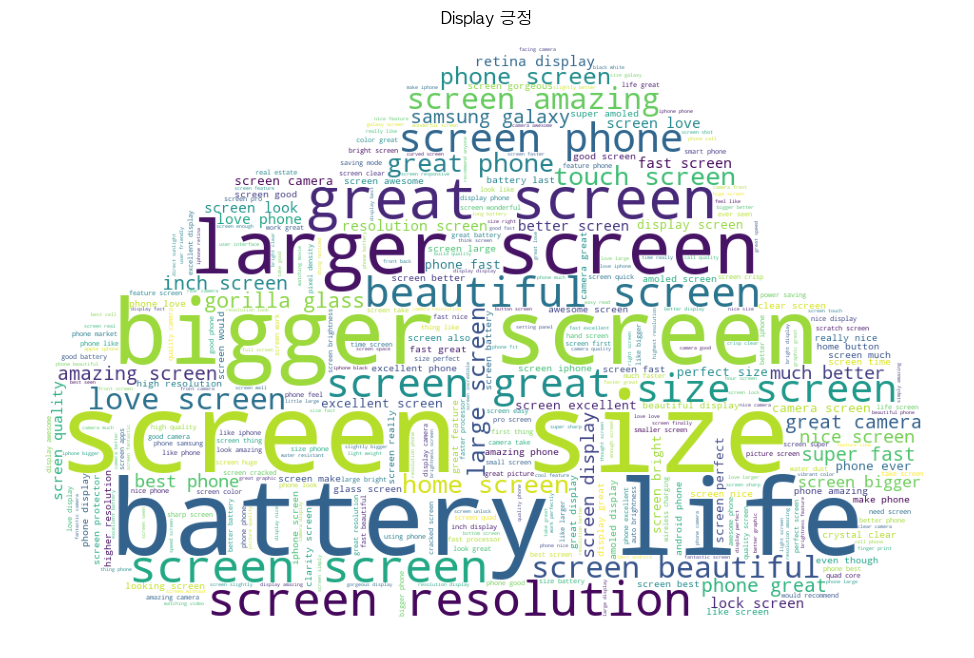

In [42]:
with tf.device(device_name):
    w = WordCloud(width=1500, height=1200, mask = img, #colormap='Blues'
                  background_color='white', max_words=500).fit_words(dict(lst_tfidf[0]))
    plt.figure(figsize=(15,8))
    _ = plt.imshow(w)
    _ = plt.axis('off')
    _ = plt.title('Display 긍정')

<Figure size 1500x800 with 0 Axes>

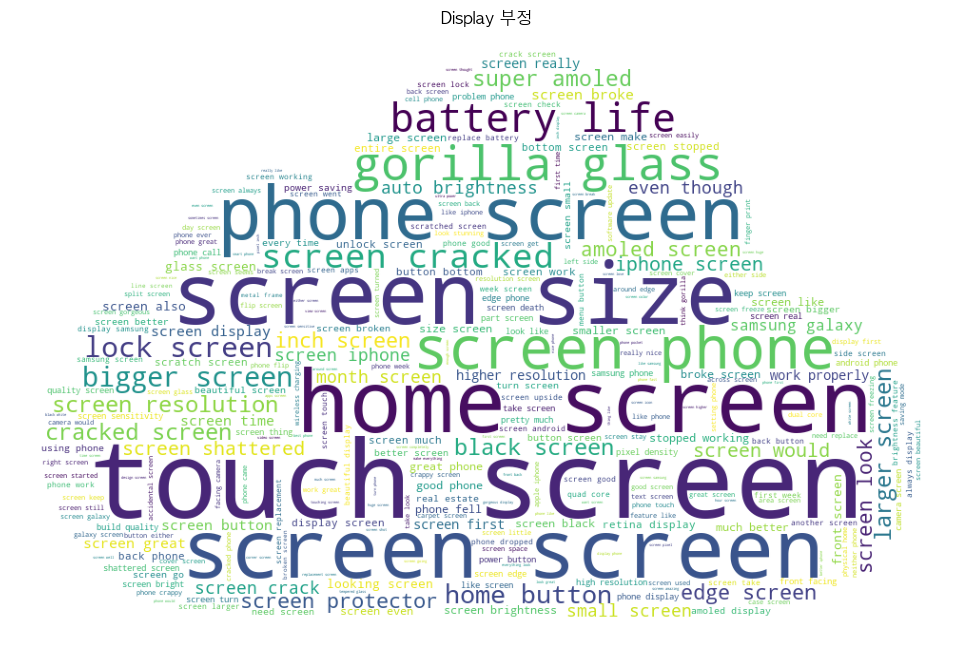

In [43]:
with tf.device(device_name):
    w = WordCloud(width=1500, height=1200, mode='RGBA', mask = img, relative_scaling=0.8, #colormap='Blues'
                  background_color='white', max_words=1000).fit_words(dict(lst_tfidf[1]))

    plt.figure(figsize=(15,8))
    _ = plt.imshow(w)
    _ = plt.axis('off')
    _ = plt.title('Display 부정')

## 일부 단어 수기 제외

In [44]:
lst = sorted(lst_tfidf[1], key=lambda x: x[1], reverse=True)

lst = [x for x in lst if 'battery' not in x[0]]
lst = [x for x in lst if 'phone' not in x[0]]
lst = [x for x in lst if 'screen screen' not in x[0]]
lst = [x for x in lst if 'button' not in x[0]]

lst_modi1 = lst

lst_modi2 = [x for x in lst if 'screen' not in x[0]]

lst_modi3 = [(x[0].replace('screen', '').replace('  ', '').strip(), x[1]) for x in lst]
lst_modi3 = [(x[0].replace('display', '').replace('  ', '').strip(), x[1]) for x in lst_modi3]
lst_modi3 = [x for x in lst_modi3 if x[0]]

lst_modi3

[('touch', 0.24602306491509587),
 ('home', 0.18540868660268095),
 ('size', 0.18184313493724477),
 ('gorilla glass', 0.1533187216137554),
 ('cracked', 0.12479430829026603),
 ('lock', 0.09983544663221282),
 ('bigger', 0.09626989496677665),
 ('black', 0.07844213663959579),
 ('cracked', 0.07844213663959579),
 ('resolution', 0.07844213663959579),
 ('larger', 0.07844213663959579),
 ('super amoled', 0.07487658497415961),
 ('protector', 0.07131103330872345),
 ('inch', 0.07131103330872345),
 ('edge', 0.07015761839698494),
 ('amoled', 0.06774548164328727),
 ('look', 0.06774548164328727),
 ('shattered', 0.06514635994005744),
 ('would', 0.0641799299778511),
 ('even though', 0.05704882664697875),
 ('crack', 0.05704882664697875),
 ('small', 0.05704882664697875),
 ('auto brightness', 0.05704882664697875),
 ('month', 0.05512384302620245),
 ('samsung galaxy', 0.05348327498154258),
 ('broke', 0.04991772331610641),
 ('time', 0.04991772331610641),
 ('great', 0.04991772331610641),
 ('higher resolution', 0.

<Figure size 1500x800 with 0 Axes>

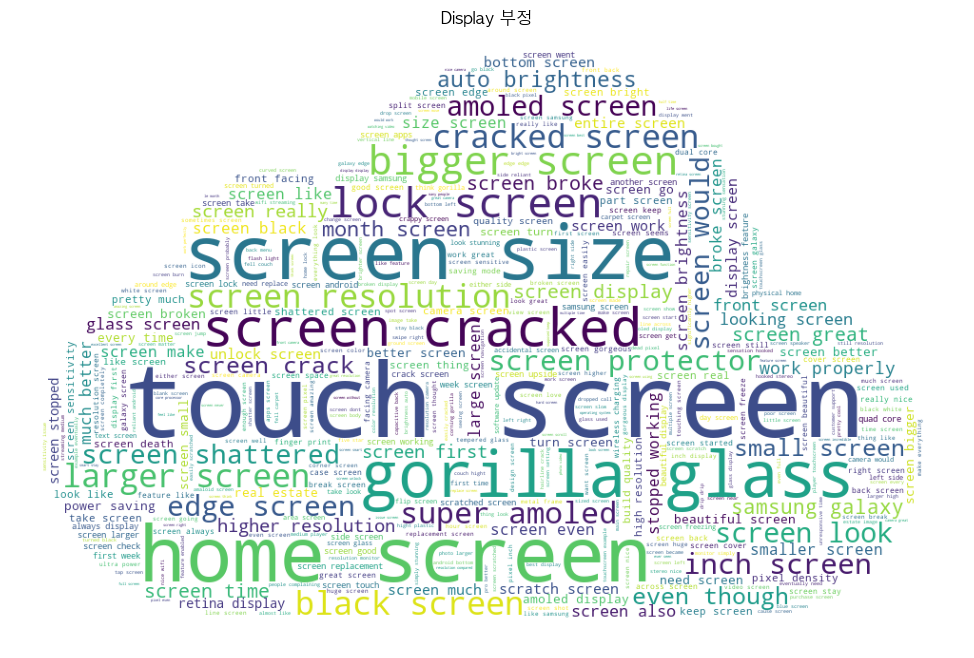

In [45]:
with tf.device(device_name):
    w = WordCloud(width=1500, height=1200, mode='RGBA', mask = img, relative_scaling=1, #colormap='Blues'
                  background_color='white', max_words=1000).fit_words(dict(lst_modi1))

    plt.figure(figsize=(15,8))
    _ = plt.imshow(w)
    _ = plt.axis('off')
    _ = plt.title('Display 부정')

<Figure size 1500x800 with 0 Axes>

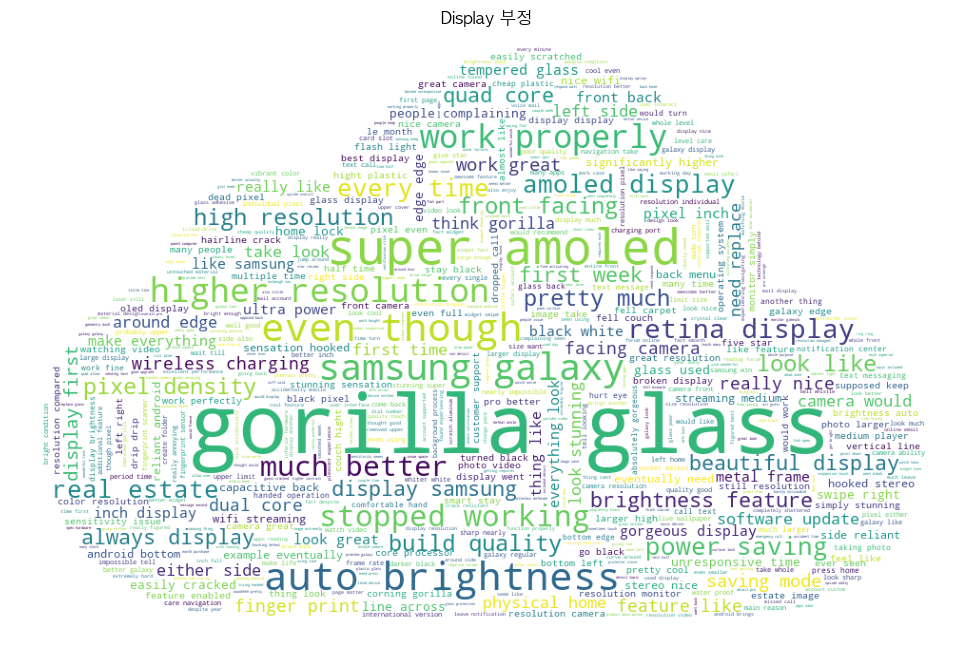

In [46]:
with tf.device(device_name):
    w = WordCloud(width=1500, height=1200, mode='RGBA', mask = img, relative_scaling=0.8, #colormap='Blues'
                  background_color='white', max_words=1000).fit_words(dict(lst_modi2))

    plt.figure(figsize=(15,8))
    _ = plt.imshow(w)
    _ = plt.axis('off')
    _ = plt.title('Display 부정')

<Figure size 1500x800 with 0 Axes>

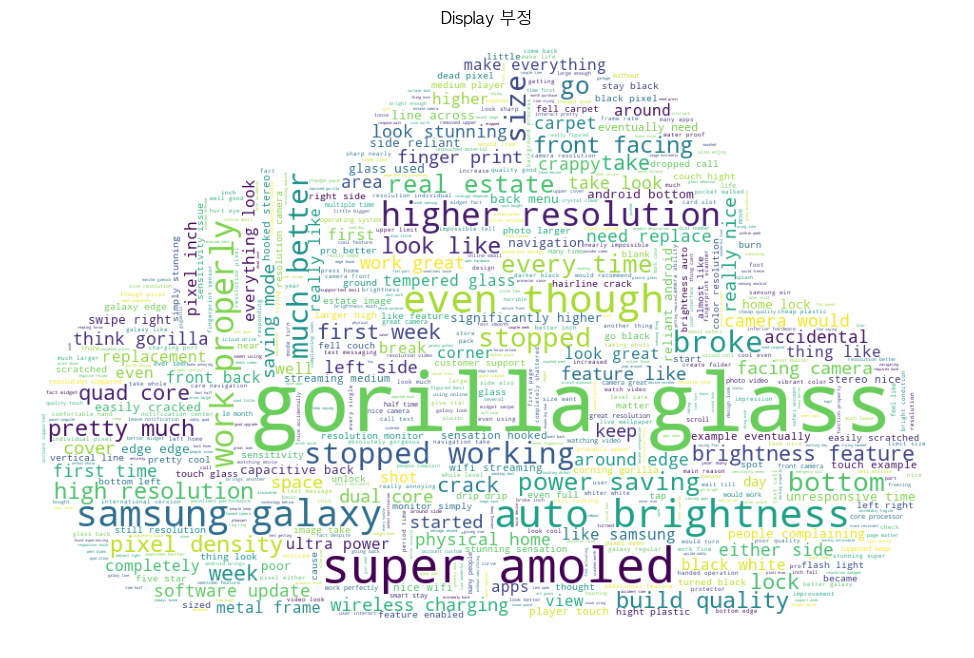

In [47]:
with tf.device(device_name):
    w = WordCloud(width=1500, height=1200, mode='RGBA', mask = img, relative_scaling=0.8, #colormap='Blues'
                  background_color='white', max_words=1000).fit_words(dict(lst_modi3))

    plt.figure(figsize=(15,8))
    _ = plt.imshow(w)
    _ = plt.axis('off')
    _ = plt.title('Display 부정')